In [82]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import numpy as np
import os



from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

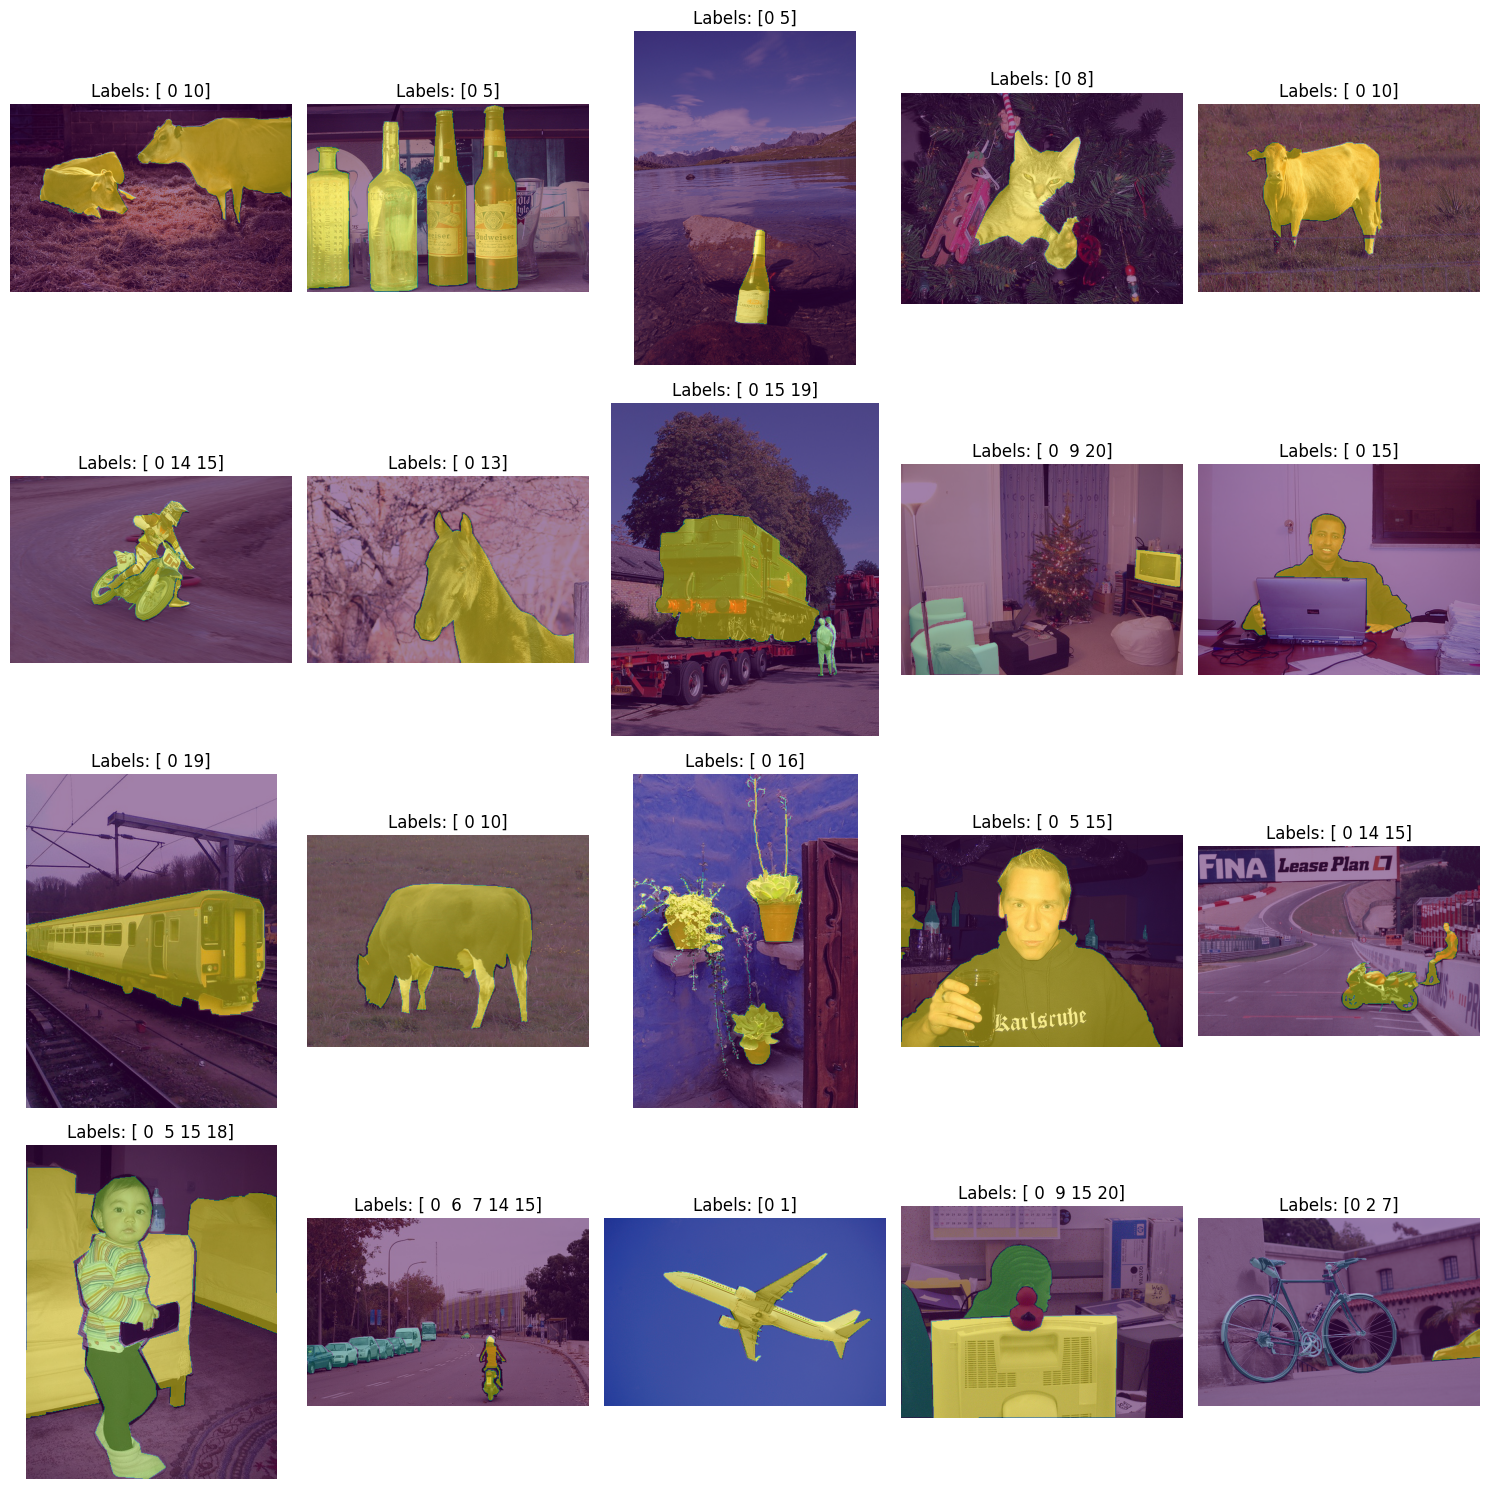

In [83]:
import matplotlib.pyplot as plt

num_images = 20
num_rows = 4
num_cols = num_images // num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i in range(num_images):
    # Get the image for the current loop iteration
    img = np.load(f'/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/img/train_{i}.npy')
    mask = np.load(f'/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/seg/train_{i}.npy')
    
    # Calculate the row and column index for the current image
    row_idx = i // num_cols
    col_idx = i % num_cols
    labels = np.unique(mask)
    # Plot the image
    axes[row_idx, col_idx].imshow(img)
    axes[row_idx, col_idx].imshow(mask, alpha=0.5)
    axes[row_idx, col_idx].axis('off')
    axes[row_idx, col_idx].set_title(f'Labels: {labels}')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


# plt.imshow(image0)
# plt.imshow(mask0, alpha=0.5)





In [84]:

class CustomDataset(Dataset):
    def __init__(self, data_folder, img_size, image_files):
        self.data_folder = data_folder
        self.img_size = img_size
        self.image_files = image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.data_folder, 'img', self.image_files[idx])
        image = np.load(img_path)

        # Load mask
        mask_path = os.path.join(self.data_folder, 'seg', self.image_files[idx])
        mask = np.load(mask_path)

        # Resize image and mask
        image = resize(image, self.img_size, anti_aliasing=True)
        mask = resize(mask, self.img_size, anti_aliasing=False, order=0)

        # Convert image and mask to PyTorch tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        mask = torch.from_numpy(mask).long()

        return (image, mask)

# Example usage

train_folder = "/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/train/"
img_size = (256, 256)

# List all image files
image_files = sorted(os.listdir(os.path.join(train_folder, 'img')))

# Split dataset into train and validation sets
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Create CustomDataset instances for train and validation sets
train_dataset = CustomDataset(train_folder, img_size, train_files)
val_dataset = CustomDataset(train_folder, img_size, val_files)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

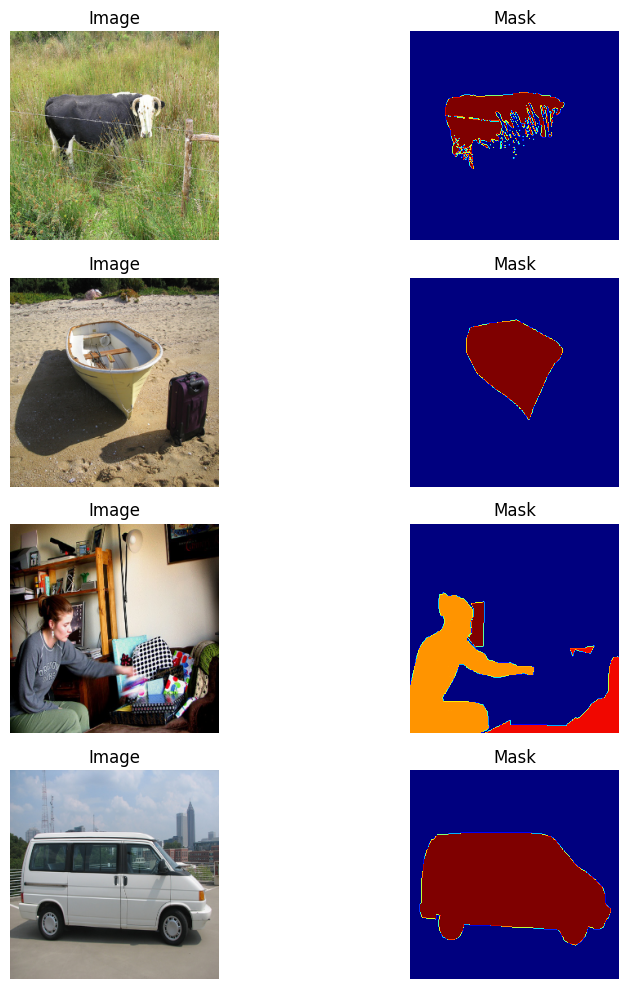

In [91]:
def plot_examples(images, masks, num_examples=4):
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 10))
    for i in range(num_examples):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        mask = masks[i].cpu().numpy()
        
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(mask, cmap='jet', vmin=0, vmax=mask.max())
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()
batch_images, batch_masks = next(iter(train_loader))

# Plot a few example images
plot_examples(batch_images, batch_masks)

In [33]:
num_classes = 21
batch_size = 16
learning_rate = 0.001
num_epochs = 10
img_size = (256, 256)

In [100]:
from torchvision.models.segmentation import fcn_resnet50

In [103]:
model = fcn_resnet50(num_classes=21)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s] 


In [105]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


In [107]:
device = 'cuda'

In [109]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the appropriate device

    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, masks in train_loader:
            # Move images and masks to device
            images = images.to(device)
            masks = masks.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)['out']

            # Calculate loss
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Define number of epochs
num_epochs = 10

# Train the model
train(model, train_loader, criterion, optimizer, num_epochs)


Epoch 1/10, Loss: 1.2882
Epoch 2/10, Loss: 0.5066
Epoch 3/10, Loss: 0.4030
Epoch 4/10, Loss: 0.3492
Epoch 5/10, Loss: 0.3183
Epoch 6/10, Loss: 0.2889
Epoch 7/10, Loss: 0.2640
Epoch 8/10, Loss: 0.2508
Epoch 9/10, Loss: 0.2353
Epoch 10/10, Loss: 0.2203


In [110]:
class TestDataset(Dataset):
    def __init__(self, data_folder, img_size, image_files):
        self.data_folder = data_folder
        self.img_size = img_size
        self.image_files = image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.data_folder, 'img', self.image_files[idx])
        image = np.load(img_path)

        # Resize image
        image = resize(image, self.img_size, anti_aliasing=True)

        # Convert image to PyTorch tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float()

        return image

# Example usage

test_folder = "/kaggle/input/kul-h02a5a-computer-vision-ga2-2024/test/"

# List all image files in the test folder
test_image_files = sorted(os.listdir(os.path.join(test_folder, 'img')))

# Create TestDataset instance for the test set
test_dataset = TestDataset(test_folder, img_size, test_image_files)

batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [116]:
def make_predictions(model, test_loader):
    device = next(model.parameters()).device  # Get the device of the model's parameters
    model.eval()  # Set model to evaluation mode
    predictions = []
    with torch.no_grad():
        for images_batch in test_loader:
            images_batch = images_batch.to(device)  # Move input data to the same device as the model
            outputs = model(images_batch)['out']
            predictions.append(outputs)
    return torch.cat(predictions)

In [117]:
test_predictions = make_predictions(model, test_loader)

In [122]:
test_predictions

tensor([[[[ 7.2243e+00,  7.2243e+00,  7.2243e+00,  ...,  8.0514e+00,
            8.0514e+00,  8.0514e+00],
          [ 7.2243e+00,  7.2243e+00,  7.2243e+00,  ...,  8.0514e+00,
            8.0514e+00,  8.0514e+00],
          [ 7.2243e+00,  7.2243e+00,  7.2243e+00,  ...,  8.0514e+00,
            8.0514e+00,  8.0514e+00],
          ...,
          [ 7.0400e+00,  7.0400e+00,  7.0400e+00,  ...,  5.6834e+00,
            5.6834e+00,  5.6834e+00],
          [ 7.0400e+00,  7.0400e+00,  7.0400e+00,  ...,  5.6834e+00,
            5.6834e+00,  5.6834e+00],
          [ 7.0400e+00,  7.0400e+00,  7.0400e+00,  ...,  5.6834e+00,
            5.6834e+00,  5.6834e+00]],

         [[-3.0048e-02, -3.0048e-02, -3.0048e-02,  ..., -1.8573e-01,
           -1.8573e-01, -1.8573e-01],
          [-3.0048e-02, -3.0048e-02, -3.0048e-02,  ..., -1.8573e-01,
           -1.8573e-01, -1.8573e-01],
          [-3.0048e-02, -3.0048e-02, -3.0048e-02,  ..., -1.8573e-01,
           -1.8573e-01, -1.8573e-01],
          ...,
     

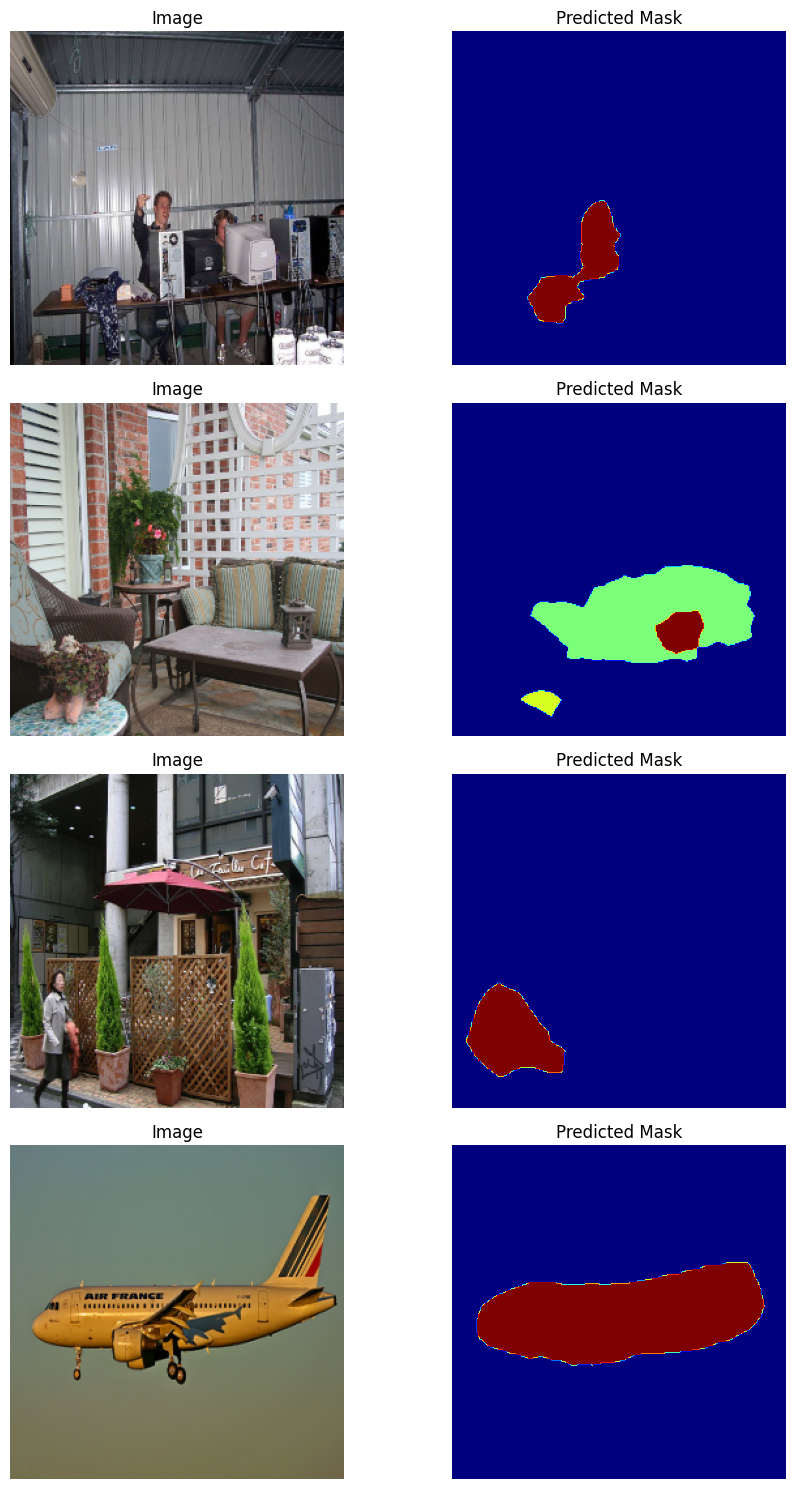

In [123]:
# Plot some example predictions
def plot_test_predictions(test_dataset, test_predictions, num_examples=4):
    test_loader = DataLoader(test_dataset, batch_size=num_examples, shuffle=False)
    images_batch = next(iter(test_loader))
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 15))
    for i in range(num_examples):
        image = images_batch[i].permute(1, 2, 0).cpu().numpy()
        prediction = test_predictions[i].argmax(dim=0).cpu().numpy()  # Convert logits to class predictions
        
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(prediction, cmap='jet', vmin=0, vmax=prediction.max())
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Plot some example predictions
plot_test_predictions(test_dataset, test_predictions)
